In [63]:
import pandas as pd
import numpy as np
import anndata as ad

from skmisc.loess import loess

import os
import os.path as osp
from os import listdir

import matplotlib.pyplot as plt
from matplotlib import rcParams

from PIL import Image

from functools import reduce

from scipy.spatial.distance import cdist

from hepaquery.structures import VeinData, Model
import hepaquery.visual as viz
import hepaquery.utils as ut

import re
import datetime


In [14]:
rcParams["figure.facecolor"] = "white"

In [15]:

TAG = re.sub(":| |-|\\.|","",str(datetime.datetime.today()))
TAG = TAG + "-cluster-5-analysis"

REPO_DIR = osp.dirname(osp.abspath(os.getcwd()))
DATA_DIR = osp.join(REPO_DIR,"data/h5ad-cca")
RESULTS_DIR = osp.join(REPO_DIR,"res",TAG)

if not osp.exists(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)
    
GENE_LIST_DIR = osp.join(REPO_DIR,"data/gene-lists/cluster_5")

SCALE_FACTOR = 2.801

CLUSTER_DIR = "../rsc/cluster/"

SAVE_RESULTS = False

In [16]:
# Get data paths
PTHS = list(filter(lambda x: x.endswith("h5ad"),os.listdir(DATA_DIR)))
PTHS = {p:osp.join(DATA_DIR,p) for p in PTHS }

data_set = {n:ad.read_h5ad(p) for n,p in PTHS.items()}
new_names = {k:d.uns["sample"] + "-" + d.uns["replicate"] for k,d in data_set.items()}
data_set = dict((new_names[k],d) for k,d in data_set.items())
    
data_set

{'CN65-C1': AnnData object with n_obs × n_vars = 647 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-D1': AnnData object with n_obs × n_vars = 684 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-C2': AnnData object with n_obs × n_vars = 626 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN16-E1': AnnData object with n_obs × n_vars = 1348 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-C1': AnnData object with n_obs × n_vars = 673 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 's

In [17]:
exclude = ["CN65-C1","CN65-C2","CN16-D1", "CN16-E1"]

for ex in exclude:
    data_set.pop(ex)

data_set

{'CN73-D1': AnnData object with n_obs × n_vars = 684 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN73-C1': AnnData object with n_obs × n_vars = 673 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-D1': AnnData object with n_obs × n_vars = 663 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN16-D2': AnnData object with n_obs × n_vars = 487 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sample'
     obsm: 'vein_distances',
 'CN65-D2': AnnData object with n_obs × n_vars = 629 × 9655
     obs: '_x', '_y', 'x', 'y', 'sample', 'replicate'
     var: 'gene'
     uns: 'img', 'mask', 'replicate', 'sa

In [18]:
genes = ut.load_genelist(GENE_LIST_DIR,
                         filter_tag = "",
                        )

In [19]:
for sample in data_set.keys():
    cluster_pth = osp.join(CLUSTER_DIR,sample.replace("-","_")+".tsv")
    cluster_info = pd.read_csv(cluster_pth,sep="\t",header=0,index_col = 0)
    inter = data_set[sample].obs.index.intersection(cluster_info.index)
    cluster_info = cluster_info.loc[inter,:]
    data_set[sample] = data_set[sample][inter,:]
    data_set[sample].obs["cluster"] = cluster_info.cluster
    

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [21]:
for data in data_set.values():
    is_c5 = data.obs.cluster.values == 5
    crd_all = data.obs[["x","y"]].values
    crd_c5 = crd_all[is_c5,:]
    dmat = cdist(crd_c5,crd_all)
    min_dist = np.min(dmat,axis=0)
    data.obs["cluster_5_dist"] = min_dist
    

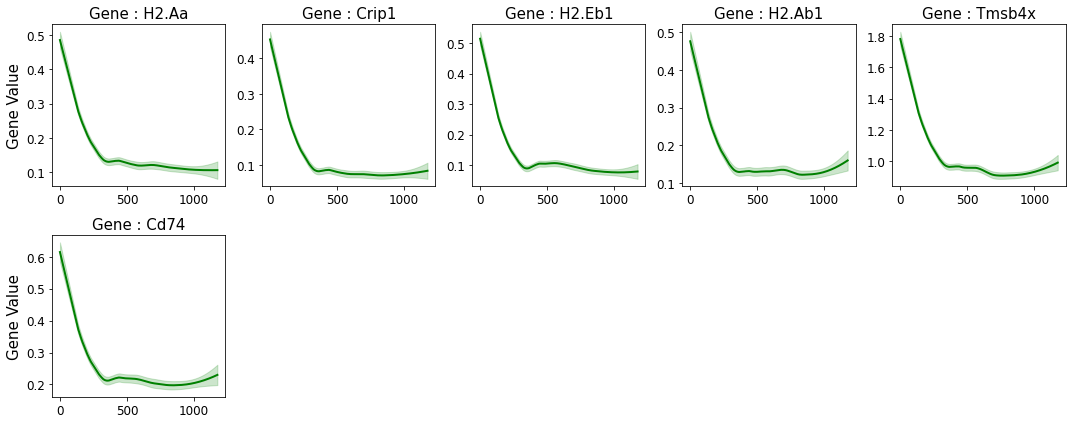

In [22]:
# set vein type to plot
vein_type = "all"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 420

# which genes to be assessed
vein_genes = genes["all"]

#define how many columns to plot
n_cols = 5 

# distance values to use

colormap = dict(envelope = "green",
                fitted = "green",
                background = "green",
               )

fig,ax = viz.get_figure(len(vein_genes),
                       n_cols = n_cols,
                       side_size = 3,
                      )

# iterate over each gene
for k,gene in enumerate(vein_genes):

    xs = np.array([])
    ys = np.array([])

    for data in data_set.values():
        if gene not in data.var.gene.values:
            print("can't find {}".format(gene))
            continue
        elif not data.obs_vector(gene).sum() > 1:
            print("no expression of {}".format(gene))
            continue


        min_dist = data.obs.cluster_5_dist.values
        xs = np.append(xs,min_dist)
        ys = np.append(ys,data.obs_vector(gene))

    if len(xs) > 0:
        smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
        viz.plot_expression_by_distance(ax[k],
                                        data = smoothed,
                                        curve_label = "cluster 5",
                                        color_scheme = colormap,
                                        include_background = False,
                                        feature_type = "Gene",
                                        feature = gene,
                                        distance_scale_factor = SCALE_FACTOR,
                                        title_fontsize = 18,
                                        label_fontsize = 15,
                                        tick_fontsize = 12,
                                        distance_unit = "um",
                                      )
        ax[k].set_xlabel("")
    if k % n_cols != 0: ax[k].set_ylabel("")

fig.tight_layout()

if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,
                         "feature-by-distance.svg"),
                facecolor = "white",
                dpi = 600)
    
plt.show()

### Check for genes that correlate well with the distance to cluster 5

In [23]:
all_data = ad.concat([data_set[x] for x in data_set.keys()])

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.


In [24]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

dist_thrs = 420

corrvals = []
pvals = []
for g in range(all_data.shape[1]):
    in_dist = all_data.obs.cluster_5_dist < dist_thrs
    spr_res = spearmanr(all_data.X[in_dist,g],all_data[in_dist,:].obs.cluster_5_dist)
    corrvals.append(spr_res.correlation)
    pvals.append(spr_res.pvalue)
    
corrvals = np.array(corrvals)
pvals = np.array(pvals)

adj_pvals = multipletests(pvals,alpha = 0.05)


/home/alma/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:123: UserWarning: Pandas requires version '2.6.8' or newer of 'numexpr' (version '2.6.6' currently installed).
  warnings.warn(msg, UserWarning)
/home/alma/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/alma/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/alma/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())
/home/alma/.local/lib/python3.7/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An inp

In [25]:
corrvals_filtered = corrvals[adj_pvals[0]]
pvals_filtered = adj_pvals[1][adj_pvals[0]]
genes_filtered = all_data.var.index.values[adj_pvals[0]]

Selected positive and negatively top correlated genes

In [55]:
ordr = np.argsort(corrvals_filtered)[::-1]

n_positive = min(sum(corrvals_filtered > 0),15)
n_negative = min(sum(corrvals_filtered < 0),15)


top_genes_positive = genes_filtered[ordr[0:n_positive]]
corrvals_positive = corrvals_filtered[ordr[0:n_positive]]
top_genes_negative = genes_filtered[ordr[::-1][0:n_negative]]
corrvals_negative = corrvals_filtered[ordr[::-1][0:n_negative]]

top_genes = dict(positive = top_genes_positive,
                 negative = top_genes_negative,
                )

top_corrvals = dict(positive = corrvals_positive,
                  negative = corrvals_negative,
                  )

no expression of Acta2
no expression of Acta2
no expression of Acta2
no expression of Myh11
no expression of Myh11
no expression of Myh11
no expression of Fbln1
no expression of Fbln1
no expression of Fbln1


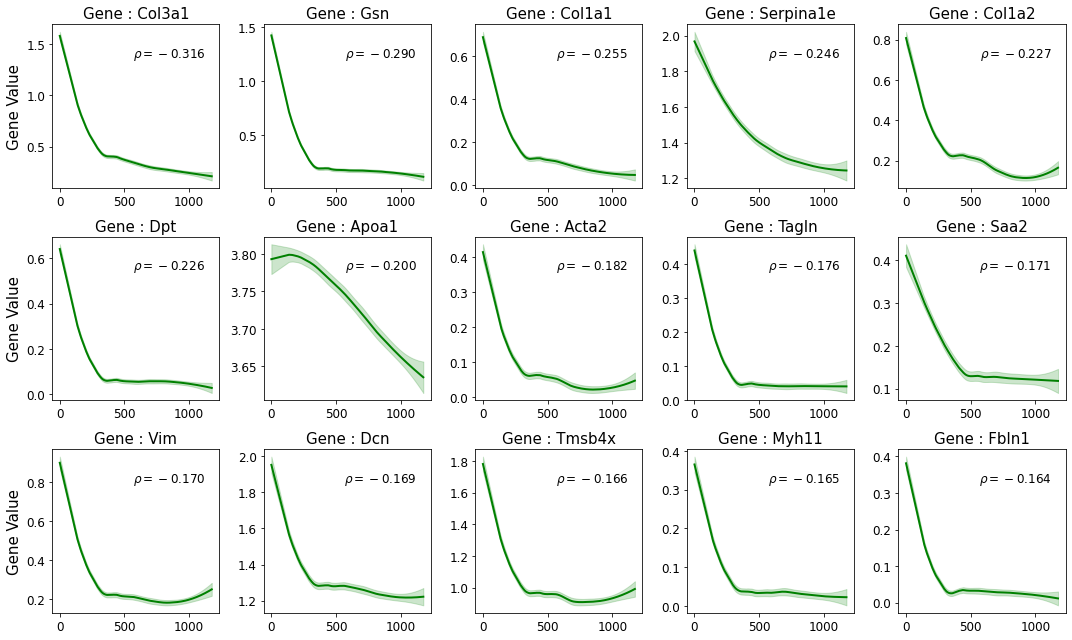

In [62]:
# set vein type to plot
gene_type = "negative"

# set to true if plots should share y-axis
share_y = False

# set within which distance from the vein
# gene expresssion should be assessed; could
# be same as RADIUS
dist_thrs = 420

#define how many columns to plot
n_cols = 5 

# distance values to use

colormap = dict(envelope = "green",
                fitted = "green",
                background = "green",
               )

fig,ax = viz.get_figure(len(top_genes[gene_type]),
                       n_cols = n_cols,
                       side_size = 3,
                      )

# iterate over each gene
for k,(gene,corrv) in enumerate(zip(top_genes[gene_type],top_corrvals[gene_type])):

    xs = np.array([])
    ys = np.array([])

    for data in data_set.values():
        if gene not in data.var.gene.values:
            print("can't find {}".format(gene))
            continue
        elif not data.obs_vector(gene).sum() > 1:
            print("no expression of {}".format(gene))
            continue


        min_dist = data.obs.cluster_5_dist.values
        xs = np.append(xs,min_dist)
        ys = np.append(ys,data.obs_vector(gene))

    if len(xs) > 0:
        smoothed = ut.smooth_fit(xs,ys,dist_thrs=dist_thrs)
        viz.plot_expression_by_distance(ax[k],
                                        data = smoothed,
                                        curve_label = "cluster 5",
                                        color_scheme = colormap,
                                        include_background = False,
                                        feature_type = "Gene",
                                        feature = gene,
                                        distance_scale_factor = SCALE_FACTOR,
                                        title_fontsize = 18,
                                        label_fontsize = 15,
                                        tick_fontsize = 12,
                                        distance_unit = "um",
                                      )
        ax[k].set_xlabel("")
        txt_y = np.array(ax[k].get_ylim())
        dy = (txt_y[-1] - txt_y[0])
        txt_x = np.array(ax[k].get_xlim())
        dx = (txt_x[-1] - txt_x[0])
        
        txt_y = txt_y[0] + 0.8 * dy
        if gene_type == "negative":
            txt_x = txt_x[0] + dx * 0.7
        else:
            txt_x = txt_x[0] + dx*0.2
            
        ax[k].text(s=r"$\rho={:0.3f}$".format(corrv),x = txt_x,
                   y= txt_y,horizontalalignment= "center",fontsize = 12)
    if k % n_cols != 0: ax[k].set_ylabel("")

fig.tight_layout()

if SAVE_RESULTS:
    fig.savefig(osp.join(RESULTS_DIR,
                         "feature-by-distance.svg"),
                facecolor = "white",
                dpi = 600)
    
plt.show()